# Implementation of IDA*

## Dependencies

In [20]:
import numpy as np
import json
from datetime import datetime
from copy import deepcopy
import bisect
from collections import defaultdict
from itertools import cycle
from typing import Dict, Tuple
import matplotlib.pyplot as plt
import random

## Constants

In [2]:
n_cores = 2

## Utils

In [3]:
def n2letter(n):
    '''0 to 'a', 1 to 'b', ... '''
    return chr(96+n)
    
def string2duration(string):
    ''' "01:50:19.3177493" to duration in seconds'''
    date =  datetime.strptime(string.split('.')[0], "%H:%M:%S")
    return date.second + 60*date.minute + 3600*date.hour

## Read Data

In [4]:
def read_data(path):
    global task_count
    global tasks
    file = open(path)
    data = json.load(file)
    nodes = data['nodes']
    tasks = dict()
    for task_str, info in nodes.items():
        task = int(task_str)
        tasks[task] = {'Data' : string2duration(info['Data']), 'Dependencies' : info['Dependencies']}
    task_count = len(tasks)
    print("Data loaded successfully. Number of tasks: " + str(task_count))

## Dependencies

In [5]:
def load_dependencies():
    global task2childs
    global task2parents
    #Tasks to child tasks / Tasks to parents / Task is terminal / Task is inital
    task2childs = {task : list() for task in tasks}
    task2parents = {task : list() for task in tasks}
    for task, info in tasks.items():
        #Add childs
        list_task_parents = info['Dependencies']
        for task_parent in list_task_parents:
            task2childs[task_parent].append(task)
        #Add parents
        task2parents[task] = tasks[task]['Dependencies']
    
def task_is_terminal(task: int):
    return len(task2childs[task]) == 0
def task_is_inital(task: int):
    return len(task2parents[task]) == 0

## Static Bottom Level

In [6]:
task2sbl = {}

def save_static_bottom_level(task : int):
    task_duration = tasks[task]["Data"]
    if task_is_terminal(task):
        sbl = task_duration
    else:
        list_sbl_child = list()
        for task_child in task2childs[task]:
            if task_child in task2sbl:
                sbl_child = task2sbl[task_child]
            else:
                sbl_child = save_static_bottom_level(task_child)
            list_sbl_child.append(sbl_child)
        sbl = max(list_sbl_child) + task_duration
                
    task2sbl[task] = sbl
    return sbl

## Calculate sbl

In [7]:
def sbl():
    for task in tasks:
        if task_is_inital(task):
            save_static_bottom_level(task)

## Heuristic

In [8]:
def h(node):
    '''Estimated remaining time of the node-schedule for reaching a terminal node.
    Must understimate true value.'''
    successor_tasks = list()
    for task, info in tasks.items():
        if task not in node.tasks_done_time: #On passe les taches déjà ajoutées
            if all([task_required in node.tasks_done_time for task_required in info['Dependencies']]):   #On ne garde que les taches dont toutes les dépendances ont été réalisées
                successor_tasks.append(task)
    if len(successor_tasks) == 0:
        return 0
    return max([task2sbl[task] for task in successor_tasks])

## Graph Class

In [51]:
class Graph:
    
    def __init__(self):
        self.tasks = tasks
        self.tasks_to_sbl = task2sbl
        self.tasks_to_parent = task2parents
        self.tasks_to_child = task2childs
        self.n_cores = n_cores
        self.nodes = list()

graph = Graph()

## Node Class

In [52]:
class Node():
    graph = graph
    
    def __init__(self, parent = None, task_to_add = None, core_where_to_add = None, time_task_start = None):
        '''Create a Node object ie a partial scheduling
        parent = parent Node, None if root
        task_to_add : task added to the partial schedule
        core_where_to_add : core where to do task
        time_task_start : instant where the core will start computing the task
        '''        
        if parent is None:
            self.parent = None
            self.tasks_done_time = dict()
            self.cores = {core_n : {"task" : -1, "task_end_time" : 0} for core_n in range(n_cores)}
            
            self.g = 0
            self.f = self.h()
                   
            self.hist = ''  
            self.schedule = dict()
            
        else:
            task_end_time = time_task_start + self.graph.tasks[task_to_add]['Data']
            
            self.parent = parent
            self.tasks_done_time = parent.tasks_done_time.copy()
            self.tasks_done_time[task_to_add] = task_end_time

            self.cores = parent.cores.copy()
            self.cores[core_where_to_add] = {"task" : task_to_add, "task_end_time" : task_end_time}
                
            self.g = max(parent.g, task_end_time)
            # self.f = max(self.g + self.h(), parent.f)
            self.f = self.g + self.h()
            
            self.schedule = parent.schedule.copy()
            self.schedule[task_to_add] = (time_task_start, task_end_time, core_where_to_add)
            self.hist = parent.hist + f"|Task {task_to_add} start at time {time_task_start} on core {core_where_to_add} "
                 
    def __repr__(self):
        string = '[' + ','.join([n2letter(task) for task in self.tasks_done_time]) + ']'
        string += ''.join([f"({core['task']} end at {core['task_end_time']})" for core in self.cores.values()])
        return string
    
    def is_solved(self):
        '''Return whether a node is a full schedule'''
        return len(self.tasks_done_time) == task_count
    
    def successors(self):                     
        '''Create and return list of child node of self'''
        childs = list()
        
        #On regarde toutes les tâches qu'on va tenter de rajouter
        for task, info in self.graph.tasks.items():
            
            #On passe les taches déjà ajoutées
            if task in self.tasks_done_time: 
                continue
            
            #On ne garde que les taches dont toutes les dépendances ont été réalisées
            if not all([task_required in self.tasks_done_time for task_required in info['Dependencies']]): 
                continue
            
            #On calcul le temps ou toutes les dépendances de task seront terminés par les coeurs   
            time_all_tasks_done = max([0] + [self.tasks_done_time[task_required] for task_required in info['Dependencies']])
                                         
            for core_n, core in self.cores.items():
                #On ne commence à faire la task que lorsque toutes les dépendances sont calculées et que le core est disponible.
                time_core_available = core["task_end_time"]
                time_task_start = max(time_all_tasks_done, time_core_available)
                
                child = Node(parent = self, task_to_add=task, core_where_to_add=core_n, time_task_start=time_task_start)    
                childs.append(child)
                
        return sorted(childs, key = lambda node: node.f)
        
    def cost(self, child_node):
        '''Return the cost of going from self to child_node, a child node of self
        '''
        res = child_node.g - self.g
        if res < 0:
            raise Exception("Cost difference is negative")
        return res
    
    def h(self):
        '''Estimated remaining time of the node-schedule for reaching a terminal node. Must understimate true value.
        '''
        successor_tasks = list()
        for task, info in self.graph.tasks.items():
            if task in self.tasks_done_time: #On passe les taches déjà ajoutées
                continue
            if not all([task_required in self.tasks_done_time for task_required in info['Dependencies']]):   #On ne garde que les taches dont toutes les dépendances ont été réalisées
                continue
            successor_tasks.append(task)
        if len(successor_tasks) == 0:
            return 0
        return max([self.graph.tasks_to_sbl[task] for task in successor_tasks])
        
    
    #Node-schedule method
    def __lt__(self, node):
        return self.f < node.f
    
    def __hash__(self):
        return int(self.f)
        
    def __eq__(self, node):
        '''Return whether a node is equal to another. Two nodes are considered equal if they have completed the same tasks and if all their cores stop working at same time.
        '''
        if self.g != node.g:
            return False       
        if self.tasks_done_time != node.tasks_done_time:
            return False
        return self.set_of_core() == node.set_of_core()
        
    def set_of_core(self):
        return set([core["task_end_time"] for core in self.cores.values()])
    
    def compute_g(self):
        return max([core["task_end_time"] for core in self.cores.values()])
    

## Search to goal

In [68]:
def search_goal(path, g, bound, goal):
    node = path[-1]
    f = g + h(node)
    if f > bound:
        return f
    if node == goal:
        return node
    minimum = np.inf
    for succ in node.successors():
        if succ not in path:
            path.append(succ)
            t = search_goal(path, g + node.cost(succ), bound, goal)
            if isinstance(t, Node):
                best_node = sorted(path[-2].successors(), key = lambda n : n.g + n.h())[0]
                path[-1] = best_node
                return best_node
            elif t < minimum:
                minimum = t
            path.pop()
    return minimum

## Search until solved

In [69]:
def search_solved(path, g, bound):
    node = path[-1]
    f = g + h(node)
    if f > bound:
        return f
    if node.is_solved():
        return node
    minimum = np.inf
    for succ in node.successors():
        if succ not in path:
            path.append(succ)
            t = search_solved(path, g + node.cost(succ), bound)
            if isinstance(t, Node):
                best_node = sorted(path[-2].successors(), key = lambda n : n.g + n.h())[0]
                path[-1] = best_node
                return best_node
            elif t < minimum:
                minimum = t
            path.pop()
    return minimum

## IDA*

In [70]:
def ida_star(root, goal = None):
    bound = h(root)*2
    path = [root]
    if goal:
        t = search_goal(path, 0, bound, goal)
    else:
        t = search_solved(path, 0, bound)
    if isinstance(t, Node):
        return t
    return 'Not found'

## Load Data

In [71]:
read_data("Graphs/custom2.json")

Data loaded successfully. Number of tasks: 23


## Load Dependencies

In [72]:
load_dependencies()

## SBL

In [73]:
sbl()

## Launch IDA*

In [74]:
final_node = ida_star(Node())
print(final_node)

[a,b,u,v,w,c,d,e,g,h,n,i,j,o,k,r,l,q,s,m,p,f,t](20 end at 54296)(6 end at 47559)


## Visualization

In [64]:
def cycle(lst: list[str]):
    x = lst.pop(0)
    lst.append(x)
    return x

def plot_schedule(node, critical_path=[]):
    schedule = node.schedule
    colors_by_proc = defaultdict(lambda:
        ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
    for id, (start, end, proc) in schedule.items():
        # cycle through the colors for this processor
        color = cycle(colors_by_proc[proc])
        colors_by_proc[proc].append(color)
        
        # handle critical path nodes
        if id in critical_path:
            critical_kwargs = {
                'edgecolor': 'red',
                'lw': 2,
                'zorder': 100,
            }
        else:
            critical_kwargs = {}
        
        # blot the bar and text
        plt.broken_barh([(start, end-start)],
                        (proc-.4, .8),
                        facecolors=color,
                        **critical_kwargs)
        plt.annotate(str(id),
                        xy=((start+end)/2, proc),
                        ha='center',
                        va='center',
                        zorder=101)
    plt.yticks(list(colors_by_proc.keys()), [f'Proc {proc}' for proc in colors_by_proc.keys()])
    plt.tight_layout()

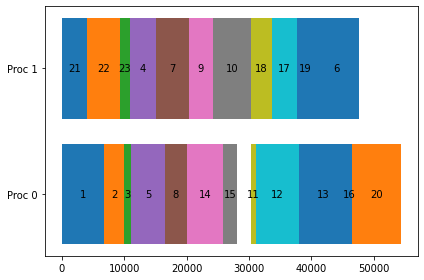

In [75]:
plot_schedule(final_node)